In [1]:
# Nếu chưa cài thư viện, hãy bỏ dấu # ở dòng dưới và chạy
# !pip install pandas numpy matplotlib seaborn mlxtend scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

print("--- Thư viện đã sẵn sàng ---")

--- Thư viện đã sẵn sàng ---


In [2]:
try:
    df = pd.read_csv('HeartDiseaseTrain-Test.csv')
    print("Đọc dữ liệu thành công!")
    display(df.head())
except Exception as e:
    print(f"Lỗi: Không tìm thấy file. Hãy kiểm tra tên file hoặc đường dẫn. Chi tiết: {e}")

Đọc dữ liệu thành công!


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [7]:
# Tạo bản sao để xử lý
df_proc = df.copy()

# Rời rạc hóa các cột số quan trọng
df_proc['age_grp'] = pd.cut(df['age'], bins=[0, 45, 60, 100], labels=['Young', 'Middle', 'Old'])
df_proc['bp_grp'] = pd.cut(df['resting_blood_pressure'], bins=[0, 130, 300], labels=['NormalBP', 'HighBP'])
df_proc['chol_grp'] = pd.cut(df['cholestoral'], bins=[0, 240, 600], labels=['NormalChol', 'HighChol'])
df_proc['hr_grp'] = pd.qcut(df['Max_heart_rate'], q=2, labels=['LowHR', 'HighHR'])

# Giữ lại các cột phân loại và cột đã xử lý
cols_keep = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 
             'exercise_induced_angina', 'slope', 'thalassemia', 'target',
             'age_grp', 'bp_grp', 'chol_grp', 'hr_grp']

df_final = df_proc[cols_keep]

# One-hot encoding (Chuyển thành 0/1)
df_encoded = pd.get_dummies(df_final).astype(int)

print("Tiền xử lý hoàn tất. Kích thước dữ liệu mới:", df_encoded.shape)

Tiền xử lý hoàn tất. Kích thước dữ liệu mới: (1025, 30)


In [8]:
print("Đang tính toán luật kết hợp (Apriori)...")

# Tìm tập phổ biến - Để support cao (0.3) để tránh treo máy
frequent_itemsets = apriori(df_encoded, min_support=0.3, use_colnames=True)

# Sinh luật
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

print(f"Tìm thấy {len(rules)} luật.")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Đang tính toán luật kết hợp (Apriori)...
Tìm thấy 87 luật.


C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:175: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
0,(target),(fasting_blood_sugar_Lower than 120 mg/ml),0.443902,0.865019,1.016794
1,(target),(exercise_induced_angina_No),0.443902,0.865019,1.303889
2,(slope_Downsloping),(target),0.331707,0.724947,1.412681
3,(target),(thalassemia_Fixed Defect),0.401951,0.783270,1.475830
4,(thalassemia_Fixed Defect),(target),0.401951,0.757353,1.475830
5,(chest_pain_type_Typical angina),(sex_Male),0.355122,0.732394,1.052881
6,(sex_Male),(fasting_blood_sugar_Lower than 120 mg/ml),0.587317,0.844320,0.992463
7,(rest_ecg_Normal),(sex_Male),0.344390,0.710262,1.021063
8,(thalassemia_Reversable Defect),(sex_Male),0.348293,0.870732,1.251753
9,(age_grp_Middle),(sex_Male),0.390244,0.740741,1.064880


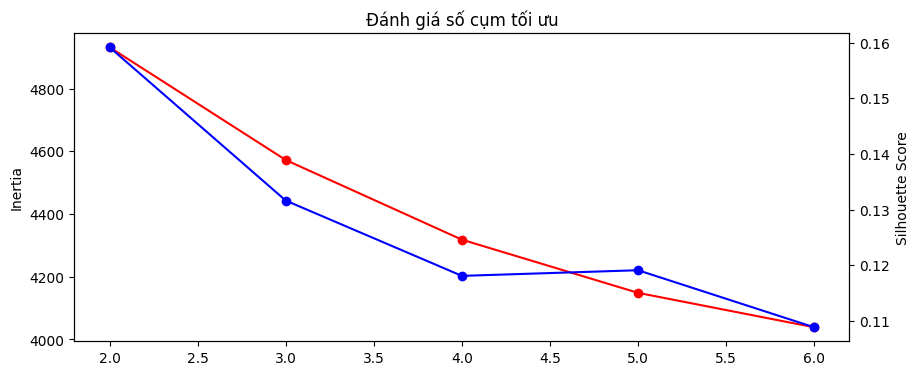

Số cụm tốt nhất gợi ý theo Silhouette: 2


In [9]:
X = df_encoded.values
sse = []
sil = []
k_range = range(2, 7) # Thử từ 2 đến 6 cụm để nhanh

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=5)
    labels = km.fit_predict(X)
    sse.append(km.inertia_)
    sil.append(silhouette_score(X, labels))

# Vẽ biểu đồ đánh giá
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(k_range, sse, 'ro-', label='SSE (Elbow)')
ax1.set_ylabel('Inertia')
ax2 = ax1.twinx()
ax2.plot(k_range, sil, 'bo-', label='Silhouette')
ax2.set_ylabel('Silhouette Score')
plt.title("Đánh giá số cụm tối ưu")
plt.show()

best_k = k_range[np.argmax(sil)]
print(f"Số cụm tốt nhất gợi ý theo Silhouette: {best_k}")

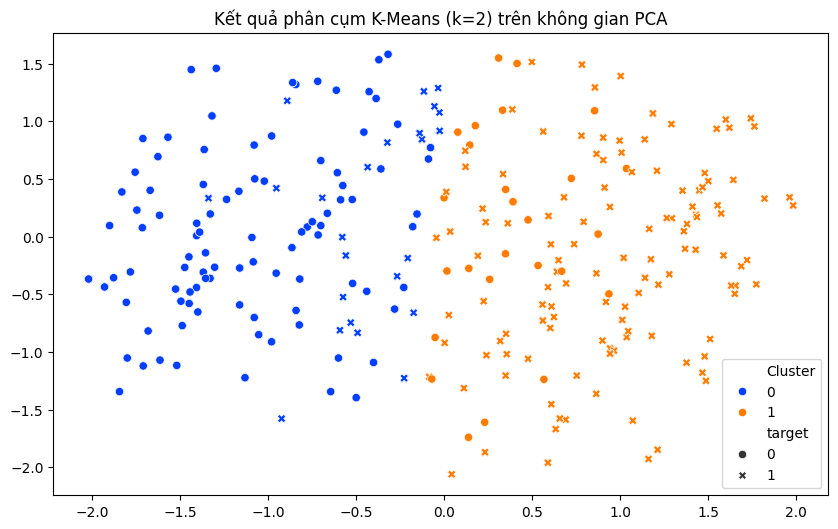

--- HOÀN THÀNH ---


In [10]:
# Chạy K-Means với k tốt nhất
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

# Dùng PCA giảm về 2 chiều để vẽ hình
pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=df['Cluster'], palette='bright', style=df['target'])
plt.title(f"Kết quả phân cụm K-Means (k={best_k}) trên không gian PCA")
plt.show()

print("--- HOÀN THÀNH ---")